Set universal variables above functions and declare them 

In [978]:
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
from plotting import plot_array
from soundGen import play
from filterAudio import low_pass_Filter, high_pass_Filter

Decay_factors = \
    [0.131, -0.2743, -0.21] 
decayFactor = 1 # Preferrably pluss sign - * (-1)**(np.random.randint(low = 1, high = 3))

delay_factors = \
    [11.73*0.75, -19.31*0.75, -7.97*0.75]
delay =   60*0.75 #1 + np.ceil(np.abs(delay_factors).max())
mixPercent = 50
decayFactor_AP = 0.131
Fs = 44100
T = 1/(Fs) 
N = Fs
amplitude = 2
frequency = [200,400,800]
t = 1
omega = 2 * np.pi


Then create code for signal

In [979]:
t_vec = np.arange(N)*T*t 
ysum = 0
sine_add = np.sin(np.linspace(-16 * np.pi,16 * np.pi,len(t_vec)))/10
omega = 2 * np.pi* sine_add
for i in range(len(frequency)):
    ysum  += amplitude * np.sin(omega * frequency[i] * t_vec)


Normalize the signal


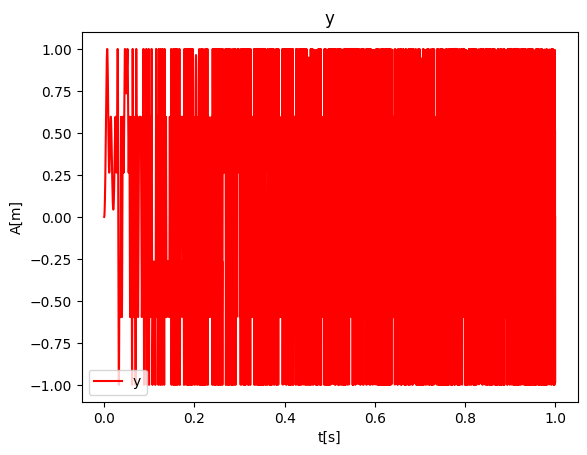

In [980]:
normalized_y = ysum/ np.max(ysum)
plt.figure()
plot_array(t_vec, normalized_y, "y", "t[s]", "A[m]", "y", "r", "-", False, "y.pdf")
plt.show()


Convolution

Set up for reverbation algo, we want n seperate intervals based on time:     

In [989]:
length = len(normalized_y)
DryWet_ = 100
Duration_inp = 5
if Duration_inp == 1:
    Duration_inp = 2
t = Duration_inp
Duration = Duration_inp
total_len = int(Duration * length)
t_vec_r = np.arange(int(N * Duration)) * T * t
x = float(length/(total_len))
DryWet = abs((DryWet_/100))
#First output original sample

length1 = int(total_len * (x)) 

length2 = int(total_len * ((Duration_inp-1) * x/3)) + length1

length3 = int(total_len * ((Duration_inp-1) * x/4)) + length2

length4 = int(total_len * ((Duration_inp-1) * x/6)) + length3

length5 = int(total_len * ((Duration_inp-1) * x/6)) + length4

length6 = int(total_len * ((Duration_inp-1) * x/12)) + length5

print(len(t_vec_r))
print(total_len)

releasek = np.ones_like(t_vec_r)
releasej = np.ones_like(t_vec_r)
releasel = np.ones_like(t_vec_r)
if Duration_inp >= 3:
    releaseg = np.linspace(1,0.75, length2 - length1+1)
    releaseh = np.linspace(1,0.5, length3 - length2+1)
    releasek = np.linspace(1,0.5, length4 - length3)
    releasej = np.linspace(1,0.5, length5 - length4)
    releasel = np.linspace(1,0.5, length6 - length5)

cych = 2205
cyc3h = 3 * cych
cyc5h = 5 * cych
cyc7h = 7 * cych
cyc9h = 9 * cych
norm_y_a = normalized_y.copy()
norm_y = list(norm_y_a) * int((Duration))

conv_y = np.zeros_like(t_vec_r)
#Release constants
g = 0
h = 0
k = 0
j = 0
l = 0


88200
88200


In [990]:
for n in range(len(t_vec_r)):
    
    if n >= length1 and n < length2:
        conv_y[n] = releaseg[g] * (norm_y[n]*0.4 - norm_y[n-length1+cych]*0.6 * DryWet)
        g += 1

    elif n >= length2 and n <= length3:
        conv_y[n] = releaseh[h] * (norm_y[n- length2]*0.4 - norm_y[n-length2+cych]*0.4 - norm_y[n- length2+cyc3h]*0.2)
        h += 1 

    elif n >= length3 and n <= length4:
        conv_y[n] = releasek[k] * (norm_y[n-length3]*0.3 - norm_y[n-length3+cych]*0.2\
             - norm_y[n- length3+cyc3h]*0.15 - norm_y[n- length3+cyc5h]*0.1)
        k += 1

    elif n >= length4 and n <= length5:
        conv_y[n] = releasej[j] * (norm_y[n-length4]*0.2 - norm_y[n-length4+cych]*0.2 - norm_y[n- length4+cyc3h]*0.1\
             - norm_y[n- length4+cyc5h]*0.05 - norm_y[n- length4+cyc7h]*0.05)
        j += 1
        
    elif n >= length5 and n < length6:
        dist = n - length5
        conv_y[n] =  releasel[l] * (norm_y[dist]*0.2 - norm_y[dist+cych]*0.01 - norm_y[dist+cyc3h]*0.01\
             - norm_y[dist+cyc5h]*0.01 - norm_y[dist+cyc7h]*0.01 - norm_y[dist+cyc9h]*0.01)
        l += 1

    else:
        
        conv_y[n] = norm_y[n]

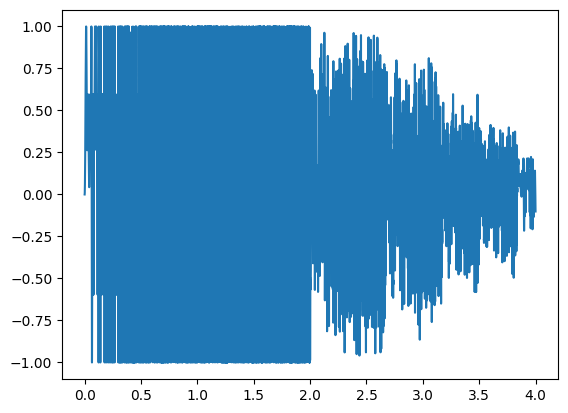

In [991]:
plt.figure()
plt.plot(t_vec_r, conv_y)
plt.show()
play(conv_y)

Try to reduce clipping of the sound by smoothing

Try to reduce noise

Generate FFT of the signal and try to adjust pitch

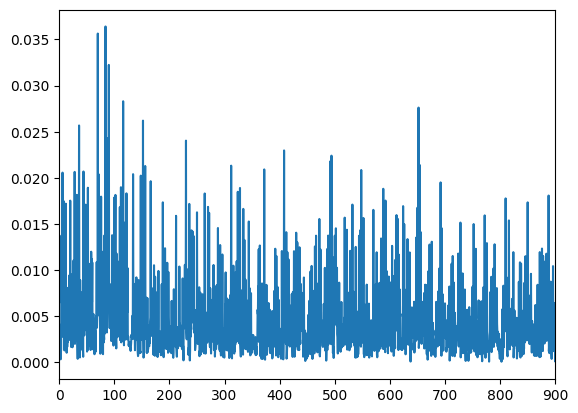

90.0
[0.03223977465501681, 0.03563732496981881, 0.036405213321902004]
[90.0]


In [992]:
length = len(new_array)

Y_k = np.fft.fft(new_array)[0:int(length/2)]/length # FFT function from numpy
Y_k[1:] = 2*Y_k[1:] # need to take the single-sided spectrum only
Pxx = np.abs(Y_k) # be sure to get rid of imaginary part
f = Fs*np.arange((length/2))/length # frequency vector
plt.figure()
plt.xlim([0, np.max(frequency)+100])
plt.plot(f, Pxx)
plt.show()



#frequency = [30, 20, 100, 240]
Powers = sorted(Pxx, reverse= False)[-len(frequency):]

frequencies = []
k = 0
tol = 1e-4

for i in range(int(length/2)):
    if abs(Powers[k] - Pxx[i]) < tol:
        frequencies.append(f[i])
        print(f[i])
        k += 1
        if k == len(Powers):
            break
    

print(Powers)
print(frequencies)